## 数値微分
関数f(x)と微小変化hより微分係数が求まります。

$$
\frac{df(x)}{dx} = lim_{h \rightarrow 0}\frac{f(x+h) - f(x)}{h}
$$

例えば、$f(x) = x^2$ で、$x=1$において、$h=0.1$の時の微分係数は下記のようになります。

In [2]:
x = 1
h = 0.1
((x+h)*(x+h)-x*x)/h

2.100000000000002

## 偏微分
NISQのパラメータを含む量子回路ではたくさんの角度が回路に変数として登場します。偏微分によって、特定のパラメータに関わる微分係数を手に入れることができます。

$$
\frac{\partial f(x,y)}{\partial x}
$$

とか、

$$
\frac{\partial f(x,y)}{\partial y}
$$

## 勾配
勾配は、この偏微分をベクトルの形に収めたものになっています。

$$
(\frac{\partial f(x,y)}{\partial x},\frac{\partial f(x,y)}{\partial y})
$$

極小値、最小値の部分では微分が0になりますので、そのような場所を探すには全ての偏微分に対して、勾配を使って更新をかけることによって極小値、最小値を探すことができます。eはここでは学習率を示します。

$$
x = x -e*\frac{\partial f(x,y)}{\partial x}\\
y = y -e*\frac{\partial f(x,y)}{\partial y}
$$

このプロセスを繰り返します。

## SGD
Stochastic Gradient Descentは確率的にサンプルを選んで勾配計算を行います。早速、RYゲートを使った回路で測定値の期待値の最小値を求めるVQEをやってみます。

In [3]:
!pip install -q blueqat

Let's check another simple circuit with X measurement.

3.140683446953395


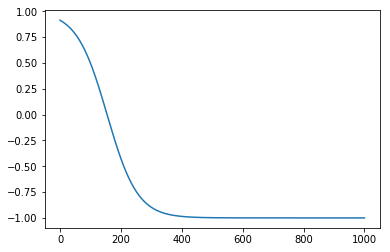

In [6]:
from blueqat import Circuit
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def abs_sq(k):
    return np.square(np.abs(k))

#Zの期待値
def exptZ(a):
    res = Circuit().ry(a)[0].run()
    return abs_sq(res[0])-abs_sq(res[1])

#初期設定
ainit = [np.random.rand()*2*np.pi]
a = ainit.copy()
h = 0.001
e = 0.01

#勾配の更新と記録
for i in range(1000):
    a.append(a[i] - e*(exptZ(a[i]+h) - exptZ(a[i]))/h)

#最終の値
print(a[-1])

#期待値のプロット
plt.plot(list(map(exptZ, a)))
plt.show()

無事VQEができました。

## 損失関数
VQEは変分原理などを覚える必要があるので、損失関数を使ってみます。これなら機械学習として覚えられます。

3.3769432741687635


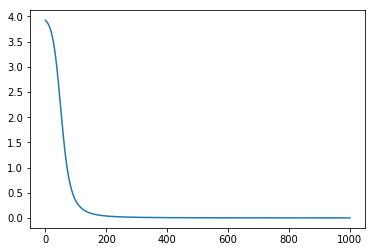

0.0007599592263280862


In [8]:
from blueqat import Circuit
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def abs_sq(k):
    return np.square(np.abs(k))

#期待値
def expt(a):
    res = Circuit().ry(a)[0].run()
    return abs_sq(res[0])-abs_sq(res[1])

#損失関数
def loss(res,tar):
    return np.square(res-tar)

#微分係数
def dfx(a,h,tgt=-1):
    return (loss(expt(a+h),tgt) - loss(expt(a),tgt))/h
#    return (expt(a+h)-expt(a))/h

#勾配
def grad(a,h,e):
    for i in range(1000):
        a.append(a[i] - e*dfx(a[i],h))
    return a

#初期化
a = [np.random.rand()*2*np.pi]
h = 0.001
e = 0.01

ra = grad(a,h,e)
print(ra[-1])

arr = [loss(expt(i),-1) for i in ra]

plt.plot(arr)
plt.show()

print(arr[-1])

## momentum SGD

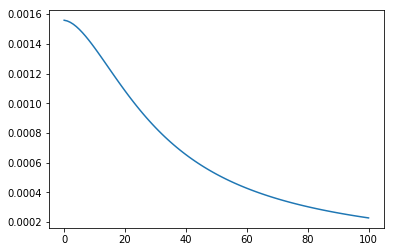

In [14]:
#momentum sgd
def msgd(a,h,e,tgt,alpha):
    p_delta = 0
    for i in range(100):
        update = -e*dfx(a[i],h,tgt) + alpha*p_delta
        a.append(a[i] + update)
        p_delta = update
    return a

#initialization
a = ainit.copy()
h = 0.001
e = 0.01

alpha = 0.9
tgt = -1

result = msgd(a,h,e,tgt,alpha)
arr = [loss(expt(i),tgt) for i in result]

plt.plot(arr)
plt.show()

## Adagrad

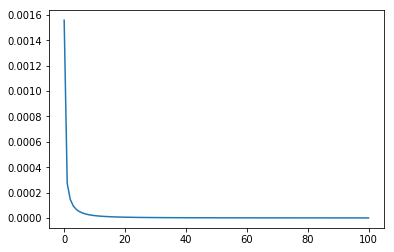

In [13]:
def adagrad(a,h,e,tgt,epsilon):
    G = epsilon
    for i in range(100):
        g = dfx(a[i],h,tgt)
        G += g*g
        update = -e/np.sqrt(G)*g
        a.append(a[i] + update)
    return a

#initialization
a = ainit.copy()
h = 0.001
e = 0.1
epsilon = 1e-08
tgt = -1

result = adagrad(a,h,e,tgt,epsilon)
arr = [loss(expt(i),tgt) for i in result]

plt.plot(arr)
plt.show()